In [ ]:
%run ../talktools.py

# MCMC: M-H worked example 

### AY 128/256 (UC Berkeley, 2024)

Here we'll use M-H to sample from a 1D Gaussian.

<img src=ma.png></img>
<img src=ma1.png></img>

#### Sampling from a 1-D Gaussian

In [2]:
import numpy as np

def gauss_prop(x0, sigma = 1.):
    '''
    the "proposal distribution". We'll use a Gaussian. 
    suggests a new value x1 to try, given a current value x0.
    '''
    x1 = np.random.normal(x0, sigma)
    return x1

def get_log_alpha(log_P, x0, x1):
    '''
    given a current position x0 and a proposed position x1, calculate alpha. 
    alpha is the ratio of log_P(x1)/log_P(x0), so log(alpha) = log_P(x1) - log_P(x0)
    Here log_P is a function.
    '''
    return log_P(x1) - log_P(x0)

def should_we_move(log_P, x0, x1):
    '''
    the "accept the candidate with probability alpha" step. Returns True if 
    you should accept x1; False otherwise. 
    '''
    log_alpha = get_log_alpha(log_P = log_P, x0 = x0, x1 = x1)

    if log_alpha >= 0:
        return True
    else:
        # generate a random number between 0 and 1
        rand_num = np.random.uniform()
        
        if np.exp(log_alpha) >= rand_num:
            return True
        else:
            return False
        
def get_n_metropolis_hasting_samples(log_P, x0, n = 10000, step = 1):
    '''
    draw n samples from a pdf P. 
    '''
    samples, num_samples = [x0], 1
    
    while num_samples < n:
        x_cur = samples[num_samples - 1]
        x_prop = gauss_prop(x0 = x_cur, sigma = step)

        # if the proposal is accepted, store the proposed step
        # else store the current step
        if should_we_move(log_P = log_P, x0 = x_cur, x1 = x_prop):
            samples.append(x_prop)
        else:
            samples.append(x_cur)
        num_samples += 1
    
    return samples


def get_acceptance_fraction(samples):
    '''
    check what fraction of the time the chain accepts the proposal
    and moves on.  
    '''
    num_accepted = 0
    for i, theta in enumerate(samples):
        if np.array_equal(samples[i-1], samples[i]):
            # if two consecutive thetas are equal, proposal was not accepted
            continue
        num_accepted += 1
        
    return num_accepted/(len(samples)-1)

In [45]:
def ln_gaussian_to_draw_from(x, mu = 5, sigma = 0.1):
    '''
    Gaussian distribution in log space
    doesn't need to be normalized
    '''
    return -(np.asarray(x)-mu)**2/(2*sigma**2)

samples = get_n_metropolis_hasting_samples(log_P = ln_gaussian_to_draw_from, 
                x0 = 1., n = 10000, step = 0.2)


print(get_acceptance_fraction(samples))

0.5004500450045004


Text(0.5, 0, 'step')

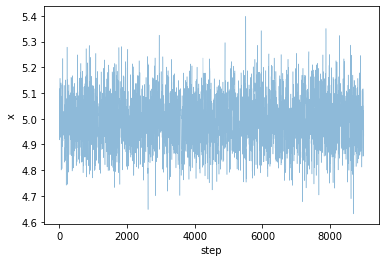

In [46]:
import pylab as plt

plt.plot(samples[1000:], alpha=0.5, lw=0.5)
plt.ylabel('x')
plt.xlabel('step')

Text(0, 0.5, 'Number')

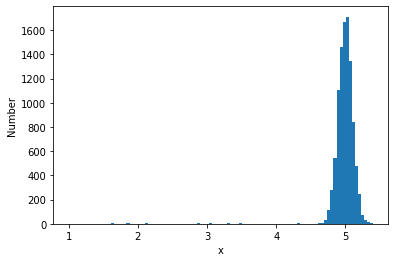

In [47]:
plt.hist(samples, bins=100)
plt.xlabel('x')
plt.ylabel('Number')

Text(0, 0.5, 'lnP')

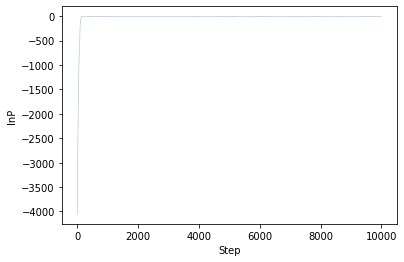

In [40]:
plt.plot(ln_gaussian_to_draw_from(samples), alpha=0.5, lw=0.5)
plt.xlabel('Step')
plt.ylabel('lnP')

### Variations to Explore
* step size
* chain length
* initial conditions

### Reformulate sampling a 1D Gaussian in terms of having an explicit likelihood function and prior

In [41]:
# log-likelihood function
def ln_like(x, mu, sigma):
    return -(np.asarray(x)-mu)**2/(2*sigma**2)

# log prior
def ln_prior(x, x_upper, x_lower):
    '''
    specific for this problem (flat priors)
    '''
    lnP = 0
    if (x < x_lower) or (x > x_upper):
        lnP = -1000
    return lnP

# log-posterior
def lnP(x, mu = 1, sigma = 0.1):
    return ln_like(x, mu, sigma) + ln_prior(x,-10, 10)

samples_like = get_n_metropolis_hasting_samples(log_P = lnP, x0 = 1., n = 10000, step = 0.2 )
get_acceptance_fraction(samples_like)

0.5059505950595059

In [ ]:
plt.plot(samples_like, alpha=0.5, lw=0.5)
plt.ylabel('x')
plt.xlabel('step')

### What modifications need to be made to apply this to >1 dimension?
* suppose we want to fit funcation form y=xm+b and a scatter term
* need to move beyond 1 dimension
 - replace mu in ln_like with mx+b
 - replace sigma in ln_like with np.sqrt(sigma_data^2 + sigma_model^2)
 - update ln_prior so that there are priors on m, b, and sigma_model
 - have initial values for m, b, sigma_model
 - update a few of the M-H functions to take in multiple variables